In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Mar 25 22:23:27 2020

@author: Guido Rezende de Alencastro Graça
"""
## First things first. Import all the relevant packages ##
import matplotlib.pyplot as plt
import numpy as np
import cv2
import matplotlib.image as mpimg


def polygon(img,xspace_bottom=0.04,xspace_upper=0.47,yspace=0.6):
    """"This function creates a mask with the polygon representing the
    central area, in with one expect to find the lanes. Polygon vertices are
    found using relative spaces of the original image. Returns a grayscale image"""
    xsize,ysize=img.shape[1],img.shape[0]
    mask=np.zeros_like(img) #Creating the blank mask
    
    ## Setting the polygon vertices
    lower_left_vertice=(xsize*xspace_bottom,ysize)
    upper_left_vertice=(xsize*xspace_upper,ysize*yspace)
    upper_right_vertice=(xsize*(1-xspace_upper),ysize*yspace)
    lower_right_vertice=(xsize*(1-xspace_bottom),ysize)
    vertices = np.array([[lower_left_vertice,upper_left_vertice, upper_right_vertice, lower_right_vertice]], dtype=np.int32)
    
    # Creating the lines on the mask
    mask=cv2.fillPoly(mask,vertices,255)    
    return mask

def color_segmentation(image,red_threshold = 10,green_threshold = 10,blue_threshold = 180):
    """This funcion applies the Color segmentation on a Polygon
    (view function Polygon).Returns a grayscale image"""
    
    # Creating copies of the umage
    color_select=np.copy(image)
    line_image=np.copy(image)    

    # Building the Polygon
    region_thresholds=cv2.cvtColor(polygon(image),cv2.COLOR_RGB2GRAY)
    
    # Color threshold
    color_threshold = [red_threshold,blue_threshold,green_threshold]
    color_area=(color_select[:,:,0]<color_threshold[0] )| (color_select[:,:,1]<color_threshold[1]) | (color_select[:,:,2]<color_threshold[2])
    
    # Combining color and area    
    for i in range(region_thresholds.shape[0]):
        for j in range(region_thresholds.shape[1]):
            if region_thresholds[i][j]!=0: region_thresholds[i][j]=True
    line_image =~color_area & region_thresholds
    return line_image

def gray(img):
    """This function recieves an RGB image and returns the grayscale image"""
    return cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

def gauss_blur(img,kernel_size=5,gamma=1):
    """This image recieves a grayscale image and apply the Gaussian Blur"""
    return cv2.GaussianBlur(img,(kernel_size,kernel_size),gamma) 

def Canny(img,low=1,high=5):
    """Recieves a grayscale image and find the edges using the
    Canny algorithm. Low and high stand for the respectives low and high
    thresholds. It returns a grayscale image"""
    canny=cv2.Canny(img,low,high)
    return canny

def combine_img(img1,img2):
    """This function combines two images. Returns the combined image"""
    return cv2.bitwise_and(img1,img2)

def Hough(img,rho=1,theta=np.pi/180,threshold = 1,min_line_lenght = 5,max_line_gap = 15):
    """This funciton applies the Hough detection of lines in a grayscale image.
    Returns the m and b coeficients of the left and right line"""
    xsize=img.shape[1]
    lines=cv2.HoughLinesP(img,rho,theta,threshold,np.array([]),min_line_lenght,max_line_gap)  #Calculate the starting and ending  points of the lines
    
    #Creating lists for interpolate
    right,left=[[],[]],[[],[]] 
    for line in lines:
        for x1,y1,x2,y2 in line:
            m=(y2-y1)/(x2-x1)
            
            #Classify by position and slope
            if m>0 and (min(x1,x2)>xsize/2):
                right[0]+=[x1,x2]
                right[1]+=[y1,y2]        
            elif m<0 and (max(x1,x2)<xsize/2):
                left[0]+=[x1,x2]
                left[1]+=[y1,y2]          
   
    #Interpolate the points 
    m_right,b_right=np.polyfit(right[0],right[1],1)
    m_left,b_left=np.polyfit(left[0],left[1],1)
    return m_right,b_right,m_left,b_left
    
def draw_lines(img,img_RGB,m_right,b_right,m_left,b_left,yspace=0.6):
    """This funciton creates the
    Returns the m and b coeficients of the left and right line"""
    line_image=np.copy(img_RGB)*0     #Creating the blank mask
    ysize=img.shape[0]
    
    #Calculating the four points of the lines
    PR1 =(int((ysize*yspace-b_right)/m_right),int(ysize*yspace))
    PR2=(int((ysize-b_right)/m_right),ysize)
    PL1=(int((ysize*yspace-b_left)/m_left),int(ysize*yspace))
    PL2=((int((ysize-b_left)/m_left),ysize))
    
    #Creating the lines
    cv2.line(line_image,PR1,PR2,[255,0,0],5)  #Creating the right line in the mask
    cv2.line(line_image,PL1,PL2,[255,0,0],5)  #Creating the left line in the mask
    return line_image

def lines_identifier(image):  
    """this functions combines all the previous functions.
    Recieves an image and returs the same images but with the lines 
    highlighted"""
    
    
    xsize,ysize=image.shape[1],image.shape[0] #Getting the image size
    original_image=np.copy(image)  #Saving a copy of the original image
    
    ## Color Segmentation
    image2=cv2.cvtColor(color_segmentation(image),cv2.COLOR_GRAY2RGB)

    ## Convert to gray scale:
    Gray=gray(image2)     #Create the greytone image
    
    ## Gaussian Blur:
    blur_gray=gauss_blur(Gray)   #Applying the blur
    
    ## Canny
    edges=Canny(blur_gray)     #Applying Canny
    
    ## Polygon
    mask=polygon(edges)     #Create mask with polygon
    masked_edges=combine_img(edges,mask)   #Applying Polygon
    
    ## Hough algorithm
    m_right,b_right,m_left,b_left=Hough(masked_edges)   #Applying Hough  
    line_image=draw_lines(masked_edges,image,m_right,b_right,m_left,b_left)     #Drawing the lines 
    
    
    ## Combining images
    final_image=cv2.addWeighted(image,0.8,line_image,1,0)   #Combining images
    return final_image

def lines_on_video(file_directory,file_name,file_type):
    """This is the last function. It recieves a file directory and applies
    he lines_identifier frame by frame. Saves a video file. Returns None"""
    
    # Opening the video
    cap = cv2.VideoCapture(file_directory+file_name+file_type)
    ret, frame = cap.read()
    i=0
    # Setting up the output
    xsize,ysize=frame.shape[1],frame.shape[0]
    fourcc = cv2.VideoWriter_fourcc(*'DIVX')
    output_directory="test_videos_output/"+file_name+'_output.mp4'
    out = cv2.VideoWriter(output_directory,fourcc, 20.0, (xsize,ysize))
    while(cap.isOpened()):
        i+=1
        if i% 10 == 0: print(i) #Print the number of the frame each 10 frames. Good for keeping track of the progress
        ret, frame = cap.read() #Refresh the frame
        if (frame is None):break 
        img=lines_identifier(frame) #Calculate the lines    
        out.write(img) #save frame with line
        #if cv2.waitKey(1) & 0xFF == ord('q'): break
    cap.release()
    out.release()
    return None

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: divide by zero encountered in int_scalars


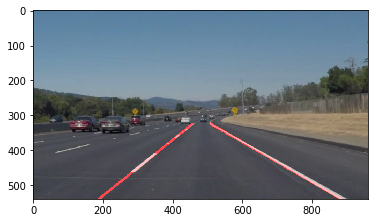

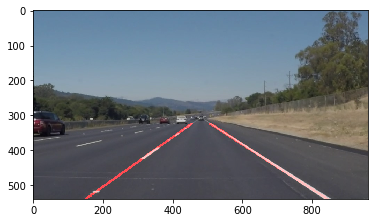

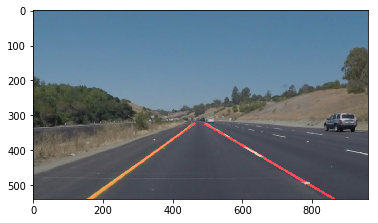

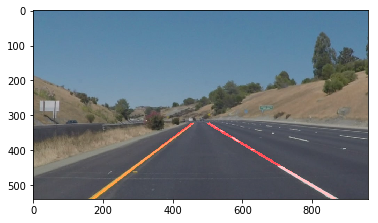

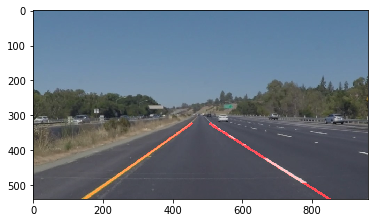

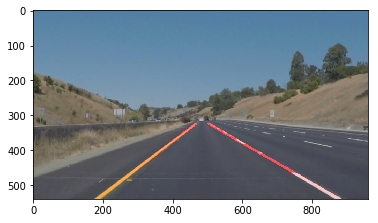

In [2]:
%matplotlib inline


files=["solidWhiteCurve.jpg","solidWhiteRight.jpg","solidYellowCurve.jpg","solidYellowCurve2.jpg","solidYellowLeft.jpg","whiteCarLaneSwitch.jpg"]
file_directory="test_images/"
output_directory="test_images_outputs/"

for i in range(len(files)):
    file_name=files[i]
    img=mpimg.imread(file_directory+file_name)
    final=lines_identifier(img)
    plt.figure()
    plt.imshow(final)
    plt.imsave(output_directory+file_name,final)

In [3]:
from IPython.display import Video

file_directory="test_videos/"
#output_directory="test_videos_output/"
file_name="solidYellowLeft"

lines_on_video(file_directory,file_name,".mp4")

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: divide by zero encountered in int_scalars


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680


In [4]:
file_directory="test_videos/"
#output_directory="test_videos_output/"
file_name="solidWhiteRight"
lines_on_video(file_directory,file_name,".mp4")

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: divide by zero encountered in int_scalars


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220


In [5]:
file_directory="test_videos/"
#output_directory="test_videos_output/"
file_name="challenge"
lines_on_video(file_directory,file_name,".mp4")

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: divide by zero encountered in int_scalars


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
